### Importacion de bibliotecas 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from tqdm import tqdm

## Info

In [30]:
df1 = pd.read_csv("../data/wikidata_artists_part1.csv")
df2= pd.read_csv("../data/wikidata_artists_part2.csv")

df = pd.concat([df1, df2], ignore_index=True)
df.head()

,artist,country,award,death,gender
0,2Baba,Nigeria,MTV Europe Music Awards,NaN,male
1,2Baba,Nigeria,جوائز إم تي في الموسيقى الأوروبية,NaN,male
2,2Baba,Nigeria,جوايز مزيكا ام تى ڤى اوروبا,NaN,male
3,2Baba,Nigeria,MTV Europe Music Awards,NaN,male
4,2Baba,Nigeria,MTV Europe Music Awards,NaN,male


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298061 entries, 0 to 298060
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   artist   298061 non-null  object
 1   country  264420 non-null  object
 2   award    298061 non-null  object
 3   death    110678 non-null  object
 4   gender   298061 non-null  object
dtypes: object(5)
memory usage: 11.4+ MB


In [32]:
df.isnull().sum()

artist          0
country     33641
award           0
death      187383
gender          0
dtype: int64

La mayoría de los artistas no tienen fecha de fallecimiento registrada, y un porcentaje carece de pais de origen. 

In [33]:
df['country'].value_counts()

country
United States     80194
United Kingdom    29477
France            15172
India             13717
Soviet Union      11810
                  ...  
Haiti                 9
Egypt                 6
Ivory Coast           5
Ethiopia              4
Croatia               3
Name: count, Length: 134, dtype: int64

## Nulos

### Rellenar valores nulos en 'country' con 'Unknown'

In [34]:
df['country'] = df['country'].fillna('Unknown')

### Convertir 'death' a booleano (True si no nulo, False si nulo) y luego a categorías

In [ ]:
df['death'] = df['death'].notna()  
df['death'].value_counts()

death
False    187383
True     110678
Name: count, dtype: int64

In [36]:
df['death'] = df['death'].map({False: 'alive', True: 'deceased'})
df['death'].value_counts()

death
alive       187383
deceased    110678
Name: count, dtype: int64

In [37]:
df.isnull().sum()

artist     0
country    0
award      0
death      0
gender     0
dtype: int64

In [38]:
df.head()

,artist,country,award,death,gender
0,2Baba,Nigeria,MTV Europe Music Awards,alive,male
1,2Baba,Nigeria,جوائز إم تي في الموسيقى الأوروبية,alive,male
2,2Baba,Nigeria,جوايز مزيكا ام تى ڤى اوروبا,alive,male
3,2Baba,Nigeria,MTV Europe Music Awards,alive,male
4,2Baba,Nigeria,MTV Europe Music Awards,alive,male


## Duplicados

### Eliminar duplicados completos

In [39]:
duplicados = df.duplicated()

print(df[duplicados])

              artist  country                                  award  death  \
3              2Baba  Nigeria                MTV Europe Music Awards  alive   
4              2Baba  Nigeria                MTV Europe Music Awards  alive   
5              2Baba  Nigeria                MTV Europe Music Awards  alive   
6              2Baba  Nigeria                MTV Europe Music Awards  alive   
7              2Baba  Nigeria                MTV Europe Music Awards  alive   
...              ...      ...                                    ...    ...   
298047  Étienne Daho   France                            藝術與文學勳章司令勳位  alive   
298048  Étienne Daho   France     Commandeur des Arts et des Lettres  alive   
298050  Étienne Daho   France  Командор ордена Мистецтв і літератури  alive   
298055  Étienne Daho   France      Comendador das Artes e das Letras  alive   
298059  Étienne Daho   France               Victoire de l'album rock  alive   

       gender  
3        male  
4        male  
5  

In [40]:
df = df.drop_duplicates()

In [41]:
duplicados = df.duplicated()

print(df[duplicados])

Empty DataFrame
Columns: [artist, country, award, death, gender]
Index: []


In [42]:
df.shape

(230990, 5)

### Contar artistas repetidos por 'artist'

In [ ]:
repeaated_name = df.value_counts(subset=['artist']).reset_index(name='counts')


repeated = repeaated_name[repeaated_name['counts'] > 1]


print("=== Artistas duplicados por 'artists' ===")
print(f"Número de combinaciones duplicadas: {len(repeated)}")
repeated.head(20)

=== Artistas duplicados por 'artists' ===
Número de combinaciones duplicadas: 2608


,artist,counts
0,Mstislav Rostropovich,3338
1,Daniel Barenboim,3303
2,Valery Gergiev,2940
3,Zubin Mehta,2892
4,Dmitri Shostakovich,2620
5,Vladimir Fedoseyev,1810
6,Yo-Yo Ma,1677
7,Frank Sinatra,1628
8,Plácido Domingo,1580
9,Nicodemus,1416


3,110 artistas aparecen más de una vez, con Mstislav Rostropovich liderando (3,332 entradas).
Esto sucede porque hay Artistas con muchos premios, incluso el mismo premio en diferentes idiomas.

## Filtrar premios en inglés

In [ ]:
palabras_no_ingles = [
    "stär um", "para", "prêmio", "premio", "prix", "voor", "de", "sus", "la", "das", "del", "der", "des",
    "el", "le", "pe", "stella", "sulla", "nagroda", "carriera", "réalta", "premi", "xelata",
    "tähti", "æresdoktor", "famen", "doktor", "oriel", "anfarwolion", "auf dem", "or merit", "kpakpando", "stäär üüb"
]

award_lang_cache = {}

def is_english_filtered(text):
    """Determina si un texto está en inglés y no contiene palabras comunes de otros idiomas.

    Args:
        text: Texto a evaluar (str).

    Returns:
        bool: True si es inglés y no contiene palabras no inglesas, False en caso contrario.
    """
    text_l = str(text).lower().strip()
    if text not in award_lang_cache:
        try:
            award_lang_cache[text] = detect(text)
        except:
            award_lang_cache[text] = "unknown"
    if award_lang_cache[text] != "en":
        return False
    for palabra in palabras_no_ingles:
        if palabra in text_l:
            return False
    return True


tqdm.pandas(desc="Filtrando premios válidos")
df = df[df['award'].notna() & df['award'].progress_apply(is_english_filtered)]
df.head()


🔍 Filtrando premios válidos: 100%|██████████| 230990/230990 [01:51<00:00, 2066.70it/s] 


,artist,country,award,death,gender
77,1995,Unknown,Victory of the album of urban musics,alive,Unknown
86,50 Cent,United States,Billboard Music Awards,alive,male
90,50 Cent,United States,Billboard Music Award,alive,male
129,A Tribe Called Quest,Unknown,Rock and Roll Hall of Fame,alive,Unknown
304,50 Cent,United States,star on Hollywood Walk of Fame,alive,male


In [17]:
df.shape

(6293, 5)

El filtrado eliminó las filas que no cumplian con el idioma, enfocándose en premios en inglés y reduciendo ruido multilingüe.

### Agrupar premios y creacion de nuevas columnas

In [ ]:

def valor_mas_comun(serie):
    """Devuelve el valor más común en una serie; si no hay moda, toma el primer no nulo.

    Args:
        serie: Serie de pandas (pd.Series).

    Returns:
        any: Valor más común o primer valor no nulo.
    """
    return serie.mode().iloc[0] if not serie.mode().empty else serie.dropna().iloc[0]

# Agrupar por artista y consolidar información
agrupado = df.groupby("artist").agg({
    "country": valor_mas_comun,
    "death": valor_mas_comun,
    "gender": valor_mas_comun,
    "award": lambda x: sorted(set(x))
}).reset_index()


agrupado["award_count"] = agrupado["award"].apply(len)


agrupado["won_grammy"] = agrupado["award"].apply(
    lambda premios: any("grammy" in premio.lower() for premio in premios)
)


agrupado["award"] = agrupado["award"].apply(lambda x: "; ".join(x))

df = agrupado
print(df.head())



                 artist        country  death   gender  \
0                  1995        Unknown  alive  Unknown   
1   5 Seconds of Summer        Unknown  alive  Unknown   
2               50 Cent  United States  alive     male   
3  A Tribe Called Quest        Unknown  alive  Unknown   
4        A. Kanyakumari          India  alive   female   

                                               award  award_count  won_grammy  
0               Victory of the album of urban musics            1       False  
1  American Music Award for New Artist of the Yea...            2       False  
2  Billboard Music Award; Billboard Music Awards;...            4       False  
3  BRIT Awards/International Group; Brit Award fo...            4       False  
4                                 Padma Shri in arts            1       False  


In [19]:
df.shape

(1632, 7)

La consolidación eliminó redundancias por artista, creando un dataset compacto con información agregada.

## Visualizaciones 

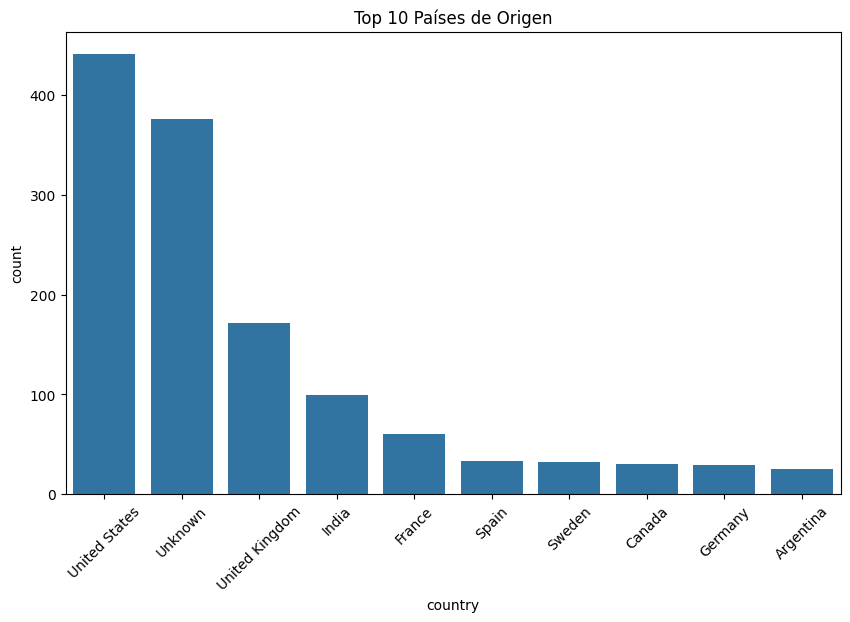

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='country', data=df, order=df['country'].value_counts().index[:10])
plt.title('Top 10 Países de Origen')
plt.xticks(rotation=45)
plt.show()

El sesgo hacia EE.UU. y Reino Unido podría subrepresentar la diversidad musical global, especialmente de regiones como América Latina, Asia o África, cuyos artistas podrían estar menos documentados o premiados en contextos anglosajones.
La alta presencia de "Unknown" limita el análisis geográfico y sugiere una oportunidad para enriquecer el dataset con otras fuentes.

<Axes: title={'center': 'Distribución de premios por artista'}, ylabel='Frequency'>

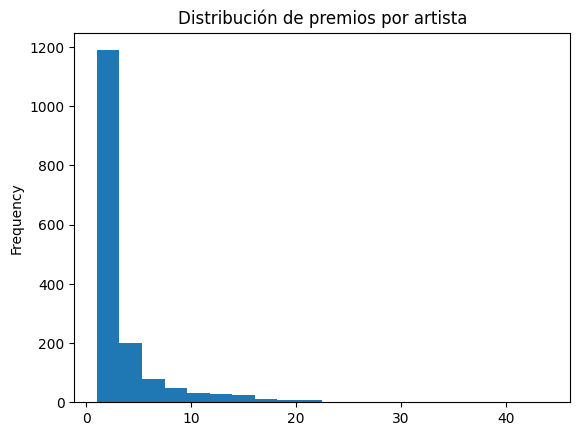

In [22]:
df["award_count"].plot.hist(bins=20, title="Distribución de premios por artista")


La cola larga sugiere que un pequeño grupo de artistas "superestrella" acumula reconocimientos, mientras que la mayoría son reconocidos esporádicamente.
El pico en 1-2 premios podría incluir premios comunes como "Billboard Music Award" o "American Music Award".

<Axes: title={'center': 'Distribución de artistas según premios Grammy'}, ylabel='count'>

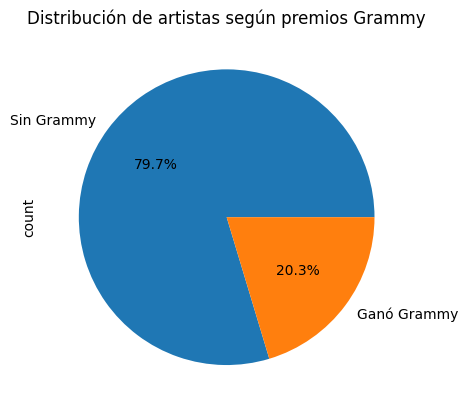

In [26]:
df["won_grammy"].value_counts().plot.pie(autopct='%1.1f%%', labels=["Sin Grammy", "Ganó Grammy"], title="Distribución de artistas según premios Grammy")


La minoría con Grammys sugiere que otros premios (Billboard, American Music Awards) son más frecuentes entre estos artistas.

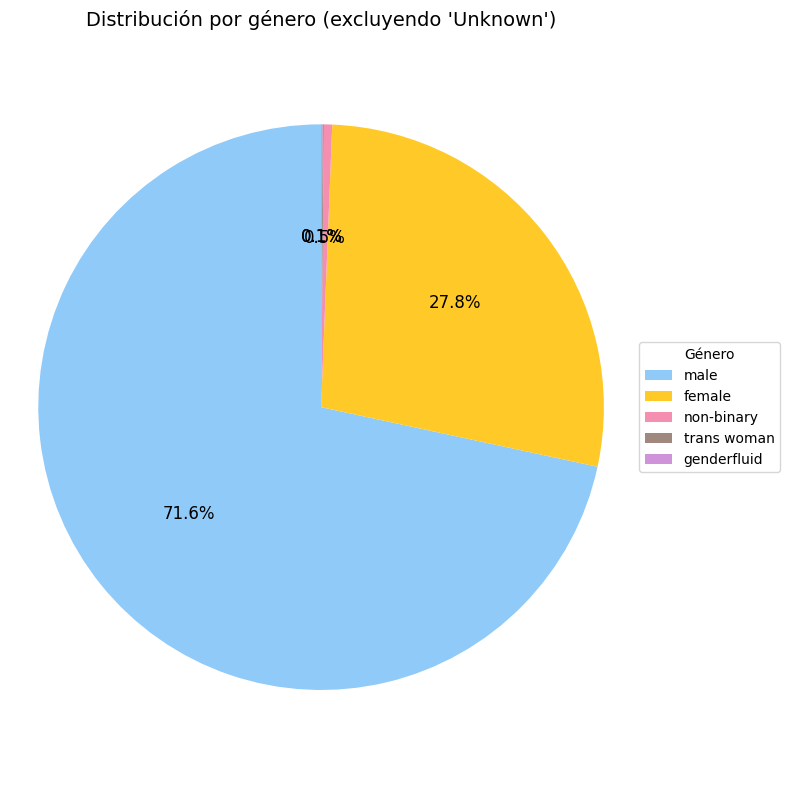

In [ ]:

gender_counts = df[df["gender"] != "Unknown"]["gender"].value_counts()


colors = ["#90caf9", "#ffca28", "#f48fb1", "#a1887f", "#ce93d8"]


plt.figure(figsize=(8, 8))
plt.pie(
    gender_counts,
    labels=None,  
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title("Distribución por género (excluyendo 'Unknown')", fontsize=14)
plt.axis("equal")


plt.legend(
    labels=gender_counts.index,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Género"
)

plt.tight_layout()
plt.show()



La gráfica muestra una distribución de género muy desigual: los hombres (male) representan el 71.6%, las mujeres (female) 27.8%, y las personas no binarias solo 0.5%. Las categorías "trans woman" y "genderfluid" no tienen porcentajes visibles, lo que sugiere que su representación es mínima o nula.